# A demo notebook for XoFTR using a batch of image pairs

In [1]:
# Run once
import os
os.chdir("..")
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
%matplotlib inline

In [2]:
# Functions for preprocessing images
def preprocess_image(img, device, resize=None, df=None, padding=None):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape[:2]
    if resize is not None:
        scale = resize / max(h, w)
        w_new, h_new = int(round(w*scale)), int(round(h*scale))
    else:
        w_new, h_new = w, h
    
    if df is not None:
        w_new, h_new = map(lambda x: int(x // df * df), [w_new, h_new])
    
    img = cv2.resize(img, (w_new, h_new))
    scale = np.array([w/w_new, h/h_new], dtype=np.float)
    if padding:  # padding
        pad_to = max(h_new, w_new)
        img, mask = pad_bottom_right(img, pad_to, ret_mask=True)
        mask = torch.from_numpy(mask).to(device)
    else:
        mask = None
    img = torch.from_numpy(img)[None][None].to(device).float() / 255.0

    mask = F.interpolate(mask[None][None].float(),
                        scale_factor=0.125,
                        mode='nearest',
                        recompute_scale_factor=False)[0].bool()

    return img, scale, mask

def pad_bottom_right(inp, pad_size, ret_mask=False):
    assert isinstance(pad_size, int) and pad_size >= max(inp.shape[-2:]), f"{pad_size} < {max(inp.shape[-2:])}"
    mask = None
    if inp.ndim == 2:
        padded = np.zeros((pad_size, pad_size), dtype=inp.dtype)
        padded[:inp.shape[0], :inp.shape[1]] = inp
        if ret_mask:
            mask = np.zeros((pad_size, pad_size), dtype=bool)
            mask[:inp.shape[0], :inp.shape[1]] = True
    elif inp.ndim == 3:
        padded = np.zeros((inp.shape[0], pad_size, pad_size), dtype=inp.dtype)
        padded[:, :inp.shape[1], :inp.shape[2]] = inp
        if ret_mask:
            mask = np.zeros((inp.shape[0], pad_size, pad_size), dtype=bool)
            mask[:, :inp.shape[1], :inp.shape[2]] = True
    else:
        raise NotImplementedError()
    return padded, mask


In [3]:
from src.xoftr import XoFTR
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
from src.utils.data_io import DataIOWrapper

# Get default configurations
config = get_cfg_defaults(inference=True)
config = lower_config(config)

# Coarse level threshold
config['xoftr']['match_coarse']['thr'] = 0.3 # Default 0.3

# Fine level threshold
config['xoftr']['fine']['thr'] = 0.1 # Default 0.1

# It is posseble to get denser matches
# If True, xoftr returns all fine-level matches for each fine-level window (at 1/2 resolution)
config['xoftr']['fine']['denser'] = False # Default False


# XoFTR model
matcher = XoFTR(config=config["xoftr"])

# The path for weights
ckpt = "weights/weights_xoftr_640.ckpt"

# Load model
matcher.load_state_dict(torch.load(ckpt)['state_dict'],strict=True)
matcher = matcher.eval().cuda()

In [ ]:

# Paths for example image pairs
img_pair_paths = [["assets/METU_VisTIR_samples/indoor/scene_8/visible/images/IM_02798.jpg", 
                "assets/METU_VisTIR_samples/indoor/scene_8/thermal/images/IM_00006.jpg"],

                ["assets/METU_VisTIR_samples/cloudy/scene_7/visible/images/IM_04525.jpg",
                "assets/METU_VisTIR_samples/cloudy/scene_7/thermal/images/IM_01139.jpg"]]


img0_raw_list = []
img1_raw_list = []
img0_list = []
img1_list = []
scale0_list = []
scale1_list = []
mask0_list = []
mask1_list = []

for path in img_pair_paths:
    # Read images
    img0_raw = cv2.imread(path[0])
    img1_raw = cv2.imread(path[1])

    # preprocess images (resizing + pad + to tensor)
    img0, scale0, mask0 = preprocess_image(img0_raw, device='cuda', resize=640, df=8, padding=True)
    img1, scale1, mask1 = preprocess_image(img1_raw, device='cuda', resize=640, df=8, padding=True)
    
    img0_raw_list.append(img0_raw)
    img1_raw_list.append(img1_raw)
    img0_list.append(img0)
    img1_list.append(img1)
    scale0_list.append(scale0)
    scale1_list.append(scale1)
    mask0_list.append(mask0)
    mask1_list.append(mask1)
    


In [ ]:
# Create batch with padding masks
batch = {'image0': torch.cat(img0_list, 0),
          'image1': torch.cat(img1_list, 0),
          'mask0': torch.cat(mask0_list, 0),
          'mask1': torch.cat(mask1_list, 0)}

# Inference with XoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    m_bids = batch['m_bids'].cpu().numpy() # batch indices for matches
    mkpts0 = batch['mkpts0_f'].cpu().numpy() 
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf_f'].cpu().numpy()

# Seperate matches for each pair in the batch and scale them to original image resolution
sep_mkpts0 = [mkpts0[m_bids==ii] * scale0_list[ii] for ii in range(batch['bs'])] # bs: batch size
sep_mkpts1 = [mkpts1[m_bids==ii] * scale1_list[ii] for ii in range(batch['bs'])]
sep_mconf = [mconf[m_bids==ii] for ii in range(batch['bs'])]

# sep_mkpts0[0] and sep_mkpts1[0] are matches for the first image pair in the batch
# sep_mkpts0[1] and sep_mkpts1[1] are matches for the second image pair in the batch
# ...

In [6]:
# Mask outliers using RANSAC (Homography or Fundamental Matrix)

inlier_method = 'F' # F: Fundamental Matrix, H: Homography 

for ii in range(batch['bs']): # bs: batch size

    if inlier_method == 'F':
        F, inlier_mask = cv2.findFundamentalMat(sep_mkpts0[ii], sep_mkpts1[ii], cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)
    elif inlier_method == 'H':
        H_pred, inlier_mask = cv2.findHomography(sep_mkpts0[ii], sep_mkpts1[ii], cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)

    inlier_mask = inlier_mask.ravel() > 0
    sep_mkpts0[ii] = sep_mkpts0[ii][inlier_mask]
    sep_mkpts1[ii] = sep_mkpts1[ii][inlier_mask]
    sep_mconf[ii] = sep_mconf[ii][inlier_mask]

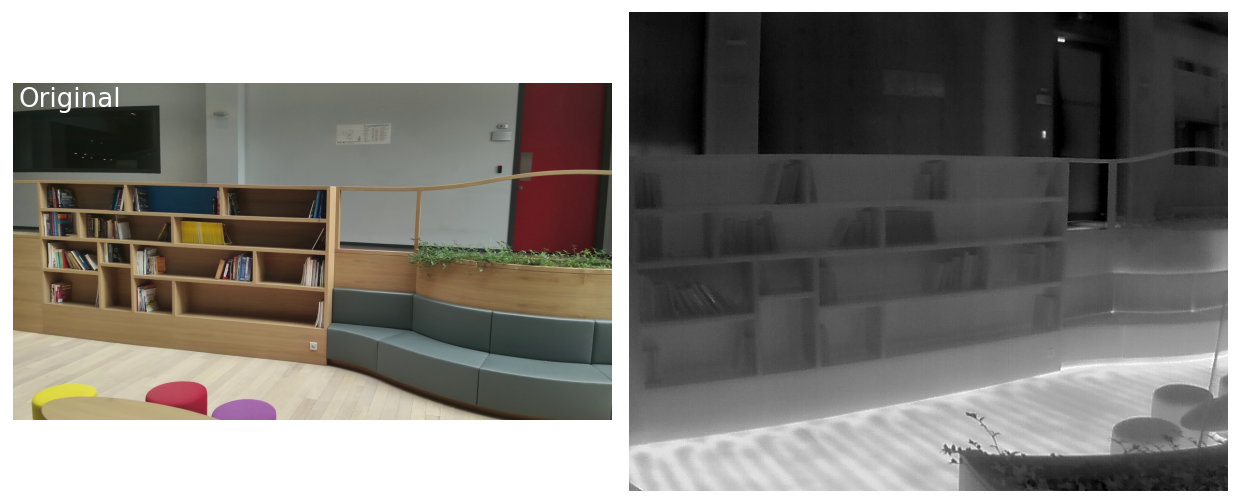

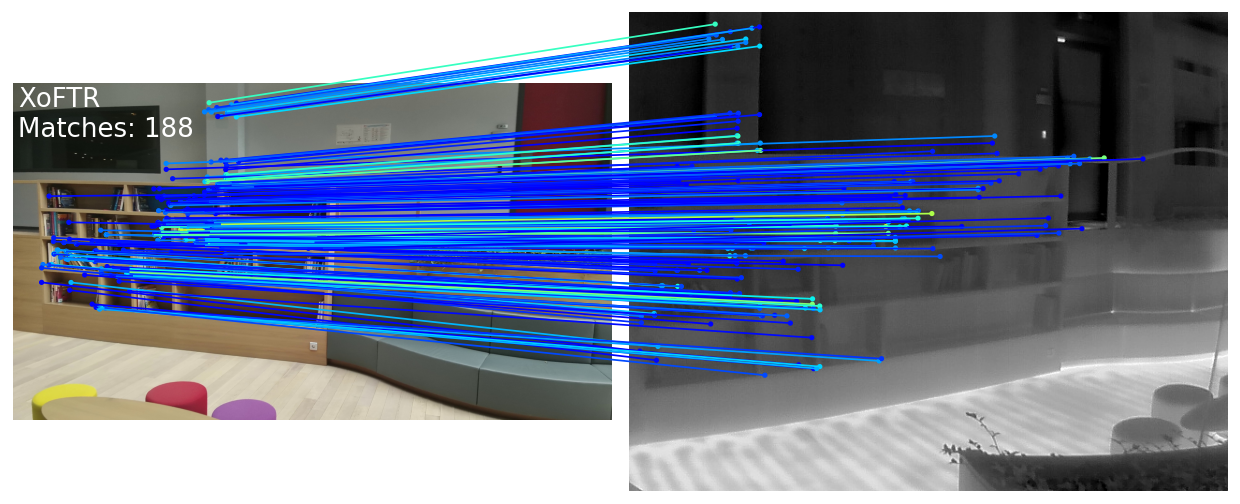

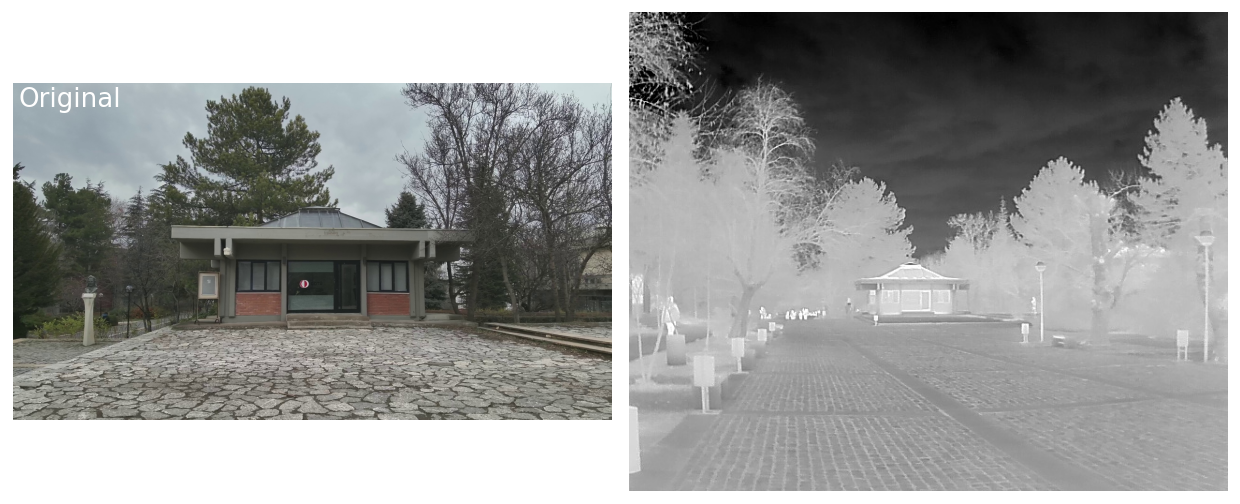

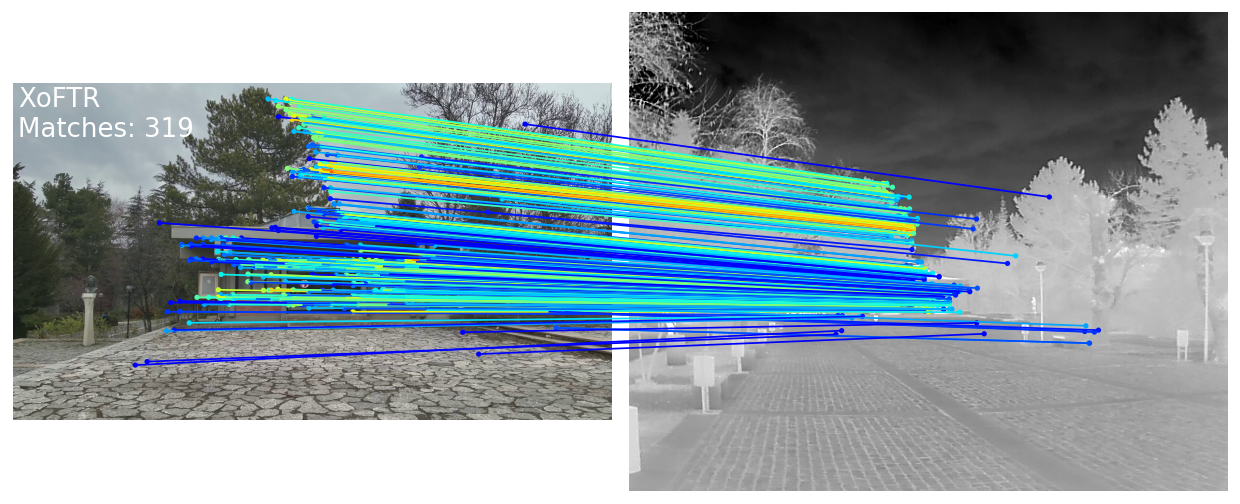

In [7]:
# Draw
for ii in range(batch['bs']):
    color = cm.jet(sep_mconf[ii])
    text = [
        'XoFTR',
        'Matches: {}'.format(len(sep_mconf[ii])),
    ]
    if len(img0_raw_list[ii].shape) == 3:
        _img0 = cv2.cvtColor(img0_raw_list[ii], cv2.COLOR_BGR2RGB)
    else:
        _img0 = img0_raw
    if len(img1_raw_list[ii].shape) == 3:
        _img1 = cv2.cvtColor(img1_raw_list[ii], cv2.COLOR_BGR2RGB)
    else:
        _img1 = img1_raw
    fig_org = make_matching_figure(_img0, _img1, np.zeros(0),  np.zeros(0),  np.zeros(0), text=["Original"], dpi=125)
    fig_match = make_matching_figure(_img0, _img1, sep_mkpts0[ii], sep_mkpts1[ii], color, text=text, dpi=125)